In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys 
import pandas as pd
from winterdrb.utils import load_real_and_bogus, load_extra_background
from winterdrb.paths import BASE_DATA_DIR
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    auc,
    balanced_accuracy_score,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import numpy as np
from winterdrb.plot import generate_single_page
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn import metrics

import logging

In [2]:
logger = logging.getLogger(__name__)
logging.basicConfig(level="INFO")

In [3]:
real_df, bogus_df = load_real_and_bogus()
real_df["known"], bogus_df["known"] = True, True
extra_bogus = load_extra_background(n_images=None)
extra_bogus["known"] = False
bogus_df = pd.concat([bogus_df, extra_bogus], axis=0)
real_df["class"], bogus_df["class"] = True, False
train_df = pd.concat([real_df, bogus_df], axis=0).reset_index(drop=True)
train_df["ztfname"] = train_df["ztfname"].replace({np.nan: None, "nan": None})

INFO:winterdrb.utils.augment:Loading 260 images from cache
INFO:root:Found 130714 background entries


In [4]:
mask = pd.isnull(train_df["distgaiabright"])
train_df.loc[mask, ["distgaiabright"]] = 100.

In [5]:
def balance_train_data(
    x_train: np.ndarray, y_train: np.ndarray
) -> tuple[np.ndarray, np.ndarray]:
    """
    Use SMOTE to balance the training data

    :param x_train: Training data
    :param y_train: Training labels
    :return: Updated training data and labels
    """
    # Augment with SMOTE
    over = SMOTE(sampling_strategy=0.5)
    steps = [("o", over)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    x_train, y_train = pipeline.fit_resample(x_train, y_train)

    return x_train, y_train

In [6]:
features = list(x for x in train_df.columns if pd.isnull(train_df[x]).sum() < 10)

float_features = []
missed_features = []

for x in features:
    try:
        train_df[x].astype(float)
        float_features.append(x)
    except ValueError:
        missed_features.append(x)

In [7]:
# float_features

In [8]:
train_features = [
    "rb",
    "distpsnr1",
    "nmtchtm",
    "chipsf",
    "fwhm",
    "mindtoedge",
    "aimage",
    "bimage",
    'aimagerat',
    'bimagerat',
    'elong',
    'nneg',
    'nbad',
    'sumrat',
    'scorr',
    'nmtchps',
    "distgaiabright"
]

In [9]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
mask = train_df[train_features].notnull().all(axis=1)
print(mask.sum(), mask.mean())
train_df = train_df[mask]
train_df.reset_index(drop=True, inplace=True)

111267 0.8497426341433612


/var/folders/y5/nrs6cfxd0d99x77tn7tlscsm0000gr/T/ipykernel_22834/2778278338.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df.replace([np.inf, -np.inf], np.nan, inplace=True)


In [10]:
n_estimator_set = [50., 100., 150.]
n_estimator_set = [100., 150., 200.]
n_estimator_set = [150.]
n_iter = 1

def train_classifier(features):

    best_clf = None
    best_pr = 0.0

    for n_estimators in n_estimator_set:
        
        kwargs = {
            "n_estimators": int(n_estimators),
            # "eval_metric": "aucpr",
            "subsample": 0.7,
        }

        all_test_true = []
        all_test_pred = []
        all_test_pred_bool = []

        all_res = None

        for i in tqdm(range(n_iter)):
            # Randomly reorder all sources
            train_sources = train_df.sample(frac=1).reset_index(drop=True)
            data_to_use = train_sources[features].to_numpy()
            mask = train_sources["class"].to_numpy()

            # prepare cross validation
            kfold = StratifiedKFold(5)

            all_pred_mask = np.ones_like(mask) * np.nan
            probs = np.ones_like(mask) * np.nan

            for train, test in kfold.split(data_to_use, mask):
                x_train, x_test = data_to_use[train], data_to_use[test]
                y_train, y_test = mask[train], mask[test]

                x_train, y_train = balance_train_data(x_train, y_train)

                clf = XGBClassifier(**kwargs).fit(
                    x_train,
                    y_train,
                )

                probs[test] = clf.predict_proba(x_test).T[1]
                all_pred_mask[test] = clf.predict(x_test)

                pred_mask = clf.predict(x_test).astype(bool)

                all_test_true += list(y_test)
                all_test_pred += list(clf.predict_proba(x_test).T[1])
                all_test_pred_bool += list(pred_mask)

            if all_res is None:
                all_res = pd.DataFrame(
                    {
                        "candid": train_sources["candid"],
                        "class": mask,
                        f"probs_{i}": probs,
                    }
                ).set_index("candid")
            else:
                new = pd.DataFrame(
                    {
                        "candid": train_sources["candid"],
                        f"probs_{i}": probs,
                    }
                )
                all_res = all_res.join(new.set_index("candid"))

            # Final classifier for use
            x_train, y_train = data_to_use, mask
            
            x_train, y_train = balance_train_data(x_train, y_train)
            
            clf = XGBClassifier(**kwargs).fit(
                x_train,
                y_train,
            )

        score = accuracy_score(all_test_true, all_test_pred_bool)
        balanced_score = balanced_accuracy_score(all_test_true, all_test_pred_bool)

        frac = np.sum(np.array(all_test_true)[np.array(all_test_pred_bool)]) / np.sum(
            all_test_true
        )
        purity = np.sum(np.array(all_test_true)[np.array(all_test_pred_bool)]) / np.sum(
            all_test_pred_bool
        )

        roc_area = roc_auc_score(all_test_true, all_test_pred)

        precision, recall, _ = precision_recall_curve(all_test_true, all_test_pred)
        pr_area = auc(recall, precision)

        logger.info(f"N estimators = {n_estimators:.0f}")
        logger.info(f"Global score {100. * score:.2f}")
        logger.info(f"Global balanced score {100. * balanced_score:.2f}")
        logger.info(f"Global recovery fraction {100. * frac:.1f}%")
        logger.info(f"Global purity {100. * purity:.1f}%")
        logger.info(f"Global roc area {100. * roc_area:.2f}")
        logger.info(f"Global precision/recall area {100. * pr_area:.2f}")

        if pr_area > best_pr:
            best_clf = clf

    return best_clf, all_res


In [11]:
clf, res_df = train_classifier(train_features)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.55s/it]
INFO:__main__:N estimators = 150
INFO:__main__:Global score 99.84
INFO:__main__:Global balanced score 73.01
INFO:__main__:Global recovery fraction 46.1%
INFO:__main__:Global purity 43.3%
INFO:__main__:Global roc area 97.30
INFO:__main__:Global precision/recall area 42.11


In [12]:
res_df

,class,probs_0
candid,,
5958985,False,3.665674e-09
7823714,False,6.092750e-09
14168299,False,3.140906e-07
8185739,False,1.924483e-08
7436017,False,2.049459e-07
...,...,...
5811739,False,8.375930e-08
12280409,False,4.933581e-08
7222427,False,4.662956e-08


In [13]:
pd.isnull(res_df["probs_0"]).sum()

0

In [14]:
mask = res_df["class"]
res_df[~mask]

,class,probs_0
candid,,
5958985,False,3.665674e-09
7823714,False,6.092750e-09
14168299,False,3.140906e-07
8185739,False,1.924483e-08
7436017,False,2.049459e-07
...,...,...
5811739,False,8.375930e-08
12280409,False,4.933581e-08
7222427,False,4.662956e-08


In [15]:
res_df.rename(columns={"probs_0": "newrb"}, inplace=True)
mask = res_df["class"]

real_df = real_df.join(res_df[["newrb"]][mask], on="candid")
bogus_df = bogus_df.join(res_df[["newrb"]][~mask], on="candid")
train_df = train_df.join(res_df[["newrb"]], on="candid")
train_df.sort_values(by="newrb", ascending=False, inplace=True)

In [16]:
features = pd.DataFrame([train_features, list(clf.feature_importances_), ]).T
features.sort_values(by=1, ascending=False, inplace=True)
features.reset_index(drop=True, inplace=True)
features

,0,1
0,rb,0.343516
1,chipsf,0.1817
2,nmtchtm,0.072436
3,distgaiabright,0.070661
4,bimagerat,0.066509
5,mindtoedge,0.055734
6,scorr,0.045994
7,elong,0.030562
8,distpsnr1,0.028462
9,bimage,0.021739


In [17]:
# import matplotlib
# matplotlib.use('qtagg')
# matplotlib.use("qtagg")

def get_clipped_bins(data, mask, central=0.95, n_bins=10):
    lower = (1. - central) / 2.
    upper = 1. - lower
    low, high = np.percentile(data, [lower, upper])

    alt_low, alt_high = min(data[mask]), max(data[mask])
    
    return np.linspace(min([low, alt_low]), max([high, alt_high]), n_bins + 1)

def plot_param(param: str, normed=True):
    all_data = train_df[param].to_numpy()
    # bins = np.linspace(np.nanmin(all_data), np.nanmax(all_data), 50)
    bins = get_clipped_bins(train_df[param].to_numpy(), train_df["class"], n_bins=50)
    plt.figure()
    plt.hist(train_df[train_df["class"]][param], label="real", alpha=0.5, bins=bins, density=normed)
    plt.hist(train_df[~train_df["class"]][param], label="bogus", alpha=0.5, bins=bins, density=normed)
    plt.xlabel(param)

    if not normed:
        plt.ylim(0., train_df["class"].sum())
    
    plt.legend()

def plot_2d(param_1: str, param_2: str):
    alpha_bogus = 5. * train_df["class"].mean()
    plt.figure()
    plt.scatter(train_df[train_df["class"]][param_1], train_df[train_df["class"]][param_2], label="real", alpha=1.0)
    plt.scatter(train_df[~train_df["class"]][param_1], train_df[~train_df["class"]][param_2], label="bogus", alpha=alpha_bogus)
    plt.xlim(train_df[train_df["class"]][param_1].min(), train_df[train_df["class"]][param_1].max())
    plt.ylim(train_df[train_df["class"]][param_2].min(), train_df[train_df["class"]][param_2].max())
    plt.xlabel(param_1)
    plt.ylabel(param_2)
    plt.legend()

In [18]:
def plot_pr(param: str):
    pr, recall, thresholds = metrics.precision_recall_curve(train_df["class"], train_df[param])
    plt.figure()

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    
    ax1.plot(thresholds[:-1], pr[1:-1])
    ax2.plot(thresholds[:-1], recall[1:-1], linestyle="--")
        
    for ax in [ax1, ax2]:    
        ax.set_xlim(0.0, 1.0)
        ax.set_ylim(0.0, 1.0)
    
    # ax2.legend()
    ax2.set_xlabel(param)
    ax1.set_ylabel("Precision")
    ax2.set_ylabel("Recall")
    
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax1.set_yticklabels([0.2, 0.4, 0.6, 0.8, 1.0])
    plt.subplots_adjust(wspace=0, hspace=0)

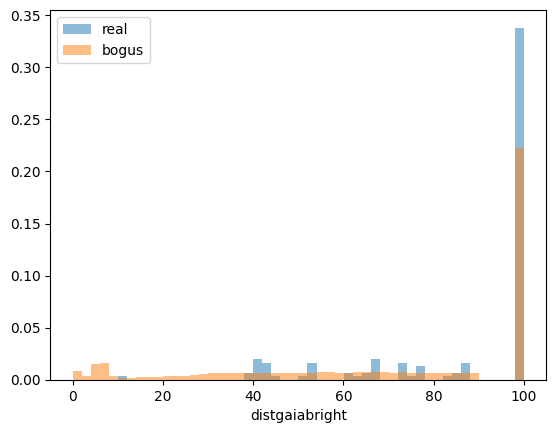

In [19]:
plot_param("distgaiabright")

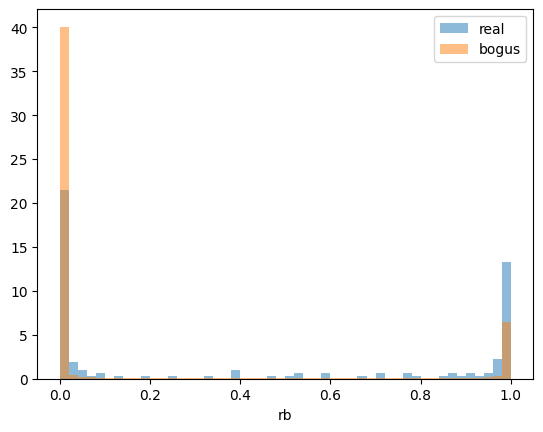

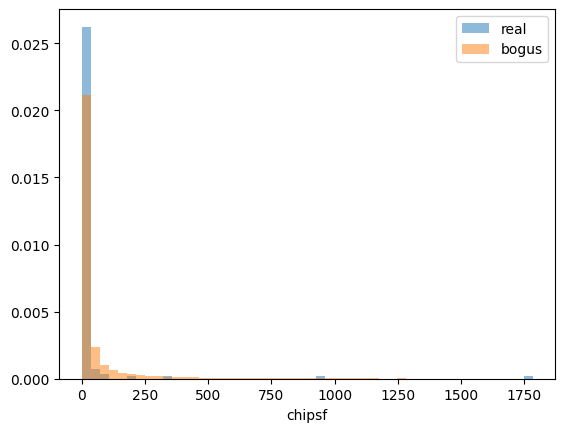

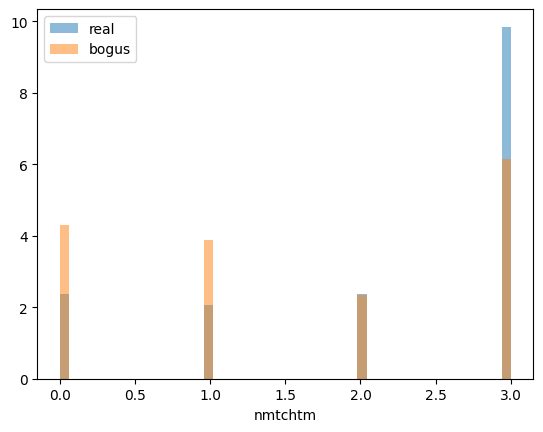

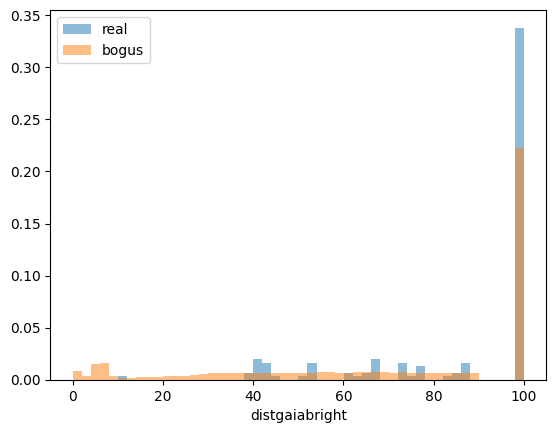

In [20]:
for _, row in features[:4].iterrows():
    plot_param(row[0])

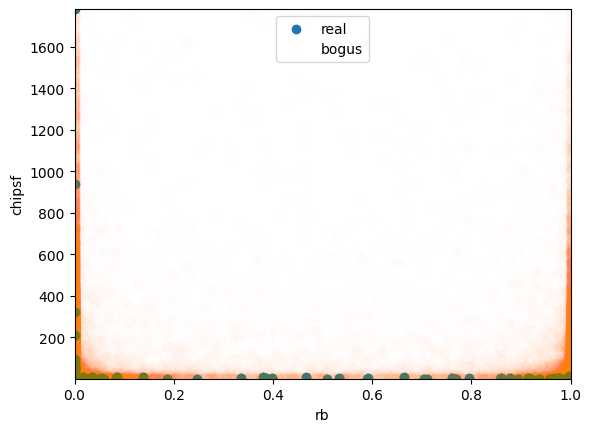

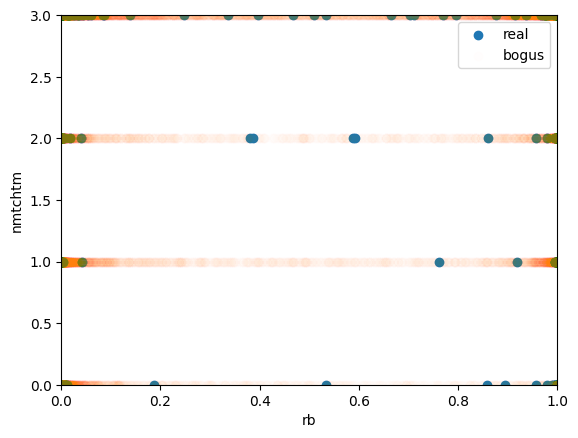

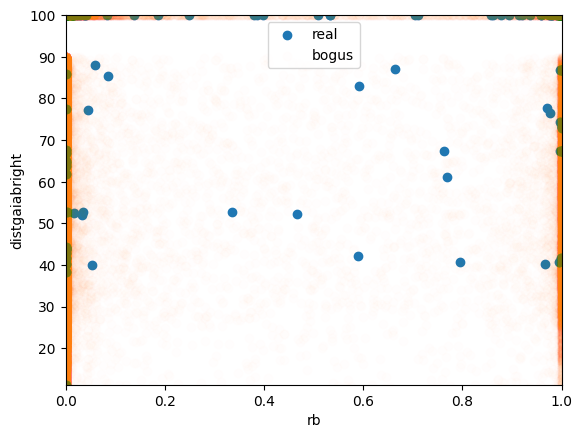

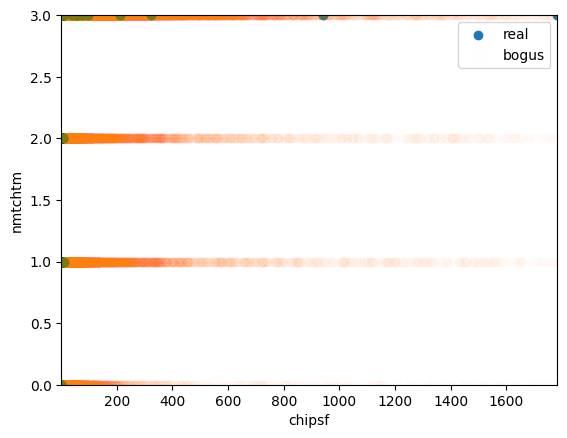

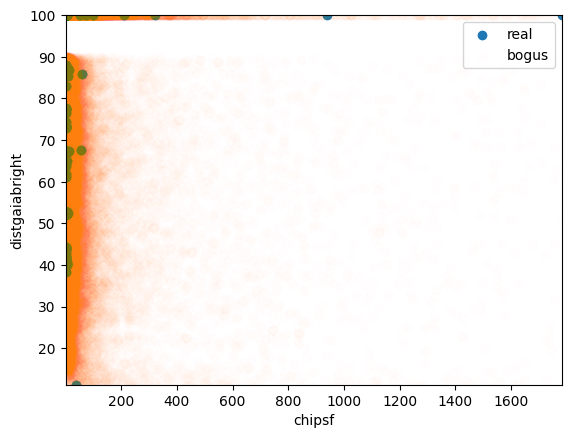

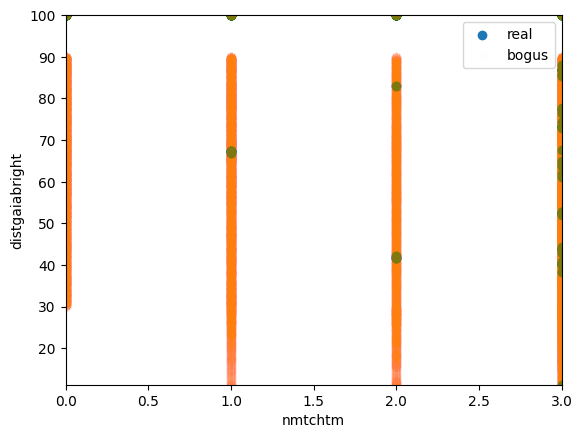

In [21]:
n_plot = 4

for i, row in features[:n_plot-1].iterrows():
    for _, row2 in features[i+1:n_plot].iterrows():
        plot_2d(row[0], row2[0])

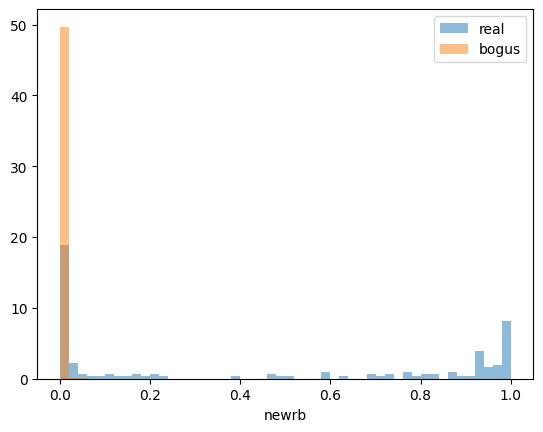

In [22]:
plot_param("newrb")

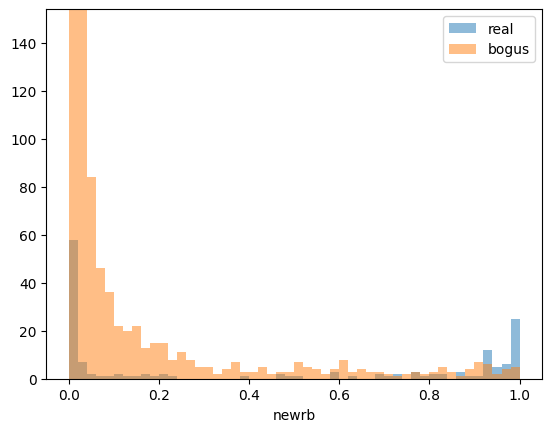

In [23]:
plot_param("newrb", normed=False)

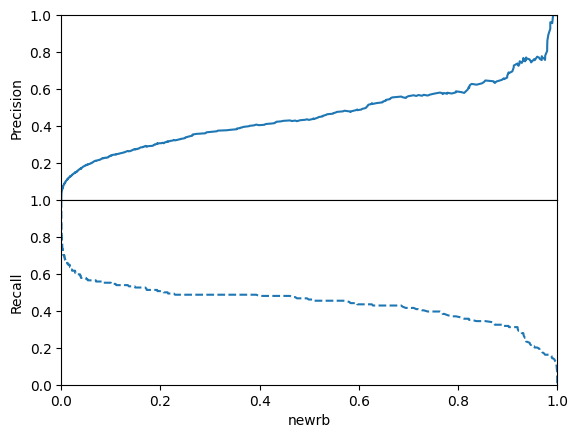

In [24]:
plot_pr("newrb")

In [25]:
print(f'Real fraction in data is {train_df["class"].mean()}')

Real fraction in data is 0.00138234370091109


In [26]:
mask = train_df["rb"] > 0.1
train_df[mask]["class"].mean(), train_df[mask]["class"].sum()/train_df["class"].sum()

(0.0037562398062571047, 0.4935064935064935)

In [27]:
mask = train_df["newrb"] > 0.000001
train_df[mask]["class"].mean(), train_df[mask]["class"].sum()/train_df["class"].sum()

(0.0045558773835384985, 0.9805194805194806)

In [28]:
mask = train_df["newrb"] > 0.0001
train_df[mask]["class"].mean(), train_df[mask]["class"].sum()/train_df["class"].sum()

(0.023551658930720303, 0.8896103896103896)

In [29]:
mask = train_df["newrb"] > 0.001
train_df[mask]["class"].mean(), train_df[mask]["class"].sum()/train_df["class"].sum()

(0.05012224938875306, 0.7987012987012987)

In [35]:
# mask = train_df["newrb"] > 0.8
# train_df[mask]["class"].mean(), train_df[mask]["class"].sum()/train_df["class"].sum()

(0.5876288659793815, 0.37012987012987014)

In [30]:
train_df[mask]

,schemavsn,publisher,objectid,candid,cutout_science,cutout_template,cutout_difference,deprecated,jd,fid,...,ztfname,distztf,field,neargaia,neargaiabright,maggaia,maggaiabright,known,class,newrb
45,0.4,WINTER-mirar,WNTR24gxcua,14247795,b'\x1f\x8b\x08\x00\xc9\xe4|h\x02\xff\xec\x97iT...,b'\x1f\x8b\x08\x00\xc9\xe4|h\x02\xff\xec\x97iT...,b'\x1f\x8b\x08\x00\xc9\xe4|h\x02\xff\xec\x97\x...,False,2.460877e+06,2,...,None,NaN,NaN,NaN,NaN,NaN,NaN,True,True,0.999990
141,0.4,WINTER-mirar,WNTR25eaabw,13912597,b'\x1f\x8b\x08\x00\x88\xdach\x02\xff\xec\x97iT...,b'\x1f\x8b\x08\x00\x88\xdach\x02\xff\xec\x9byT...,b'\x1f\x8b\x08\x00\x88\xdach\x02\xff\xec\x97y4...,False,2.460858e+06,2,...,ZTF25aauzrry,0.264257,NaN,NaN,NaN,NaN,NaN,True,True,0.999979
72,0.3,WINTER-mirar,WNTR24huvhc,7435629,b'\x1f\x8b\x08\x00\xd7\xee\xc4f\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xd7\xee\xc4f\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xd7\xee\xc4f\x02\xff\xec\x9...,False,2.460543e+06,2,...,None,NaN,NaN,NaN,NaN,NaN,NaN,True,True,0.999942
135,0.4,WINTER-mirar,WNTR25czzkg,13912216,b'\x1f\x8b\x08\x00\x99\xdach\x02\xff\xec\x99\x...,b'\x1f\x8b\x08\x00\x99\xdach\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00\x99\xdach\x02\xff\xec\x9ai4...,False,2.460858e+06,2,...,ZTF25aajygin,0.247345,NaN,NaN,NaN,NaN,NaN,True,True,0.999879
48,0.4,WINTER-mirar,WNTR24gxcua,13679702,b'\x1f\x8b\x08\x00\xd3\xcfWh\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00\xd3\xcfWh\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00\xd3\xcfWh\x02\xff\xec\x97i4...,False,2.460848e+06,2,...,None,NaN,NaN,NaN,NaN,NaN,NaN,True,True,0.999853
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85547,0.3,WINTER-mirar,WNTR24gxdgd,6977037,b'\x1f\x8b\x08\x00\xa7\xab\x9ef\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xa7\xab\x9ef\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xa7\xab\x9ef\x02\xff\xecweP...,False,2.460514e+06,2,...,None,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.001007
86072,0.3,WINTER-mirar,WNTR24ajvka,6855282,b'\x1f\x8b\x08\x00\n\xd0\x96f\x02\xff\xec\x97y...,b'\x1f\x8b\x08\x00\n\xd0\x96f\x02\xff\xec\x97i...,b'\x1f\x8b\x08\x00\n\xd0\x96f\x02\xff\xec\xd7i...,False,2.460508e+06,2,...,None,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.001007
463,0.4,WINTER-mirar,WNTR25fdquq,14481850,b'\x1f\x8b\x08\x00\xbfP\x8ah\x02\xff\xec\x98y4...,b'\x1f\x8b\x08\x00\xbfP\x8ah\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00\xbfP\x8ah\x02\xff\xec\x98w8...,False,2.460887e+06,2,...,None,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.001005
44329,0.4,WINTER-mirar,WNTR24lcjdi,9098295,b'\x1f\x8b\x08\x00\xd2w\xf8f\x02\xff\xec\xb7i4...,b'\x1f\x8b\x08\x00\xd2w\xf8f\x02\xff\xec\xb9i4...,b'\x1f\x8b\x08\x00\xd2w\xf8f\x02\xff\xec\x97y4...,False,2.460582e+06,2,...,None,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.001004


In [31]:
sg_cut = (train_df["sgscore1"] < 0.5) | (train_df["distpsnr1"] > 2.)

mask = (train_df["newrb"] > 0.001) & (~train_df["known"]) & pd.notnull(train_df["ztfname"]) & sg_cut
train_df[mask]

,schemavsn,publisher,objectid,candid,cutout_science,cutout_template,cutout_difference,deprecated,jd,fid,...,ztfname,distztf,field,neargaia,neargaiabright,maggaia,maggaiabright,known,class,newrb
47593,0.4,WINTER-mirar,WNTR23bnohh,8772342,b'\x1f\x8b\x08\x00F\xe9\xf1f\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00F\xe9\xf1f\x02\xff\xec\x99w4...,b'\x1f\x8b\x08\x00F\xe9\xf1f\x02\xff\xec\x99gS...,False,2.460577e+06,2,...,ZTF18abomthw,1.217738,NaN,NaN,NaN,NaN,NaN,False,False,0.979672
36040,0.4,WINTER-mirar,WNTR23bnohh,10930878,b'\x1f\x8b\x08\x00\xf6s\x11g\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00\xf6s\x11g\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00\xf6s\x11g\x02\xff\xec\x97y4...,False,2.460601e+06,2,...,ZTF18abomthw,1.313231,NaN,NaN,NaN,NaN,NaN,False,False,0.730711
33497,0.4,WINTER-mirar,WNTR25aiswz,11645228,b'\x1f\x8b\x08\x00V\\\x86g\x02\xff\xec\x97i4\x...,b'\x1f\x8b\x08\x00V\\\x86g\x02\xff\xec\x97i4\x...,b'\x1f\x8b\x08\x00V\\\x86g\x02\xff\xec\x97\xf9...,False,2.460690e+06,2,...,ZTF18achjbbw,0.330185,NaN,NaN,NaN,NaN,NaN,False,False,0.626174
54203,0.4,WINTER-mirar,WNTR23bnohh,8482049,b'\x1f\x8b\x08\x00\xa9\x86\xe8f\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xa9\x86\xe8f\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xa9\x86\xe8f\x02\xff\xec\x9...,False,2.460570e+06,2,...,ZTF18abomthw,1.586463,NaN,NaN,NaN,NaN,NaN,False,False,0.471779
19345,0.4,WINTER-mirar,WNTR25dupzl,13440689,b'\x1f\x8b\x08\x00\x08\xd1Oh\x02\xff\xec\x97y4...,b'\x1f\x8b\x08\x00\x08\xd1Oh\x02\xff\xec\x9ay4...,b'\x1f\x8b\x08\x00\x08\xd1Oh\x02\xff\xec\x9aw4...,False,2.460839e+06,2,...,ZTF19abhkxxh,0.473224,NaN,NaN,NaN,NaN,NaN,False,False,0.122602
54825,0.4,WINTER-mirar,WNTR23bnohh,8309413,b'\x1f\x8b\x08\x00n\xcb\xe4f\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00n\xcb\xe4f\x02\xff\xecwiT\x0...,b'\x1f\x8b\x08\x00n\xcb\xe4f\x02\xff\xecwi4\x9...,False,2.460567e+06,2,...,ZTF18abomthw,1.518786,NaN,NaN,NaN,NaN,NaN,False,False,0.120168
24720,0.4,WINTER-mirar,WNTR25cwkii,12946151,b'\x1f\x8b\x08\x00T\xc3%h\x02\xff\xec\x9b\xf97...,b'\x1f\x8b\x08\x00T\xc3%h\x02\xff\xec\x97\xf97...,b'\x1f\x8b\x08\x00T\xc3%h\x02\xff\xecwi4\xd5\x...,False,2.460811e+06,2,...,ZTF20aasvplo,1.974578,NaN,NaN,NaN,NaN,NaN,False,False,0.094790
33347,0.4,WINTER-mirar,WNTR25aikio,11638550,b'\x1f\x8b\x08\x00@\\\x86g\x02\xff\xec\x97\xf9...,b'\x1f\x8b\x08\x00@\\\x86g\x02\xff\xec\xb8yTH\...,b'\x1f\x8b\x08\x00@\\\x86g\x02\xff\xec\x97w8\x...,False,2.460690e+06,2,...,ZTF18abydeel,1.827075,NaN,NaN,NaN,NaN,NaN,False,False,0.077131
35575,0.4,WINTER-mirar,WNTR24orabt,11160399,b'\x1f\x8b\x08\x00\x13\xd4=g\x02\xff\xec\x97\x...,b'\x1f\x8b\x08\x00\x13\xd4=g\x02\xff\xec\xb8y4...,b'\x1f\x8b\x08\x00\x13\xd4=g\x02\xff\xec\xbci4...,False,2.460635e+06,2,...,ZTF17aabblop,1.759343,NaN,NaN,NaN,NaN,NaN,False,False,0.073085
42668,0.4,WINTER-mirar,WNTR23ayexj,9139689,b'\x1f\x8b\x08\x00\xee\xa1\xf9f\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xee\xa1\xf9f\x02\xff\xec\x9...,b'\x1f\x8b\x08\x00\xee\xa1\xf9f\x02\xff\xec\x9...,False,2.460583e+06,2,...,ZTF18acdzvpq,1.767926,NaN,NaN,NaN,NaN,NaN,False,False,0.067331


In [32]:
outpath = BASE_DATA_DIR / "realcands.pdf"
with PdfPages(outpath) as pdf:
    for _, row in train_df[mask].iterrows():
        generate_single_page(row, ann_fields=train_features + ["newrb", "ztfname", "ndethist", "ra", "dec", "sgscore1", "distpsnr1"])
        pdf.savefig()
        plt.close()

In [33]:
cut = 0.01

30000. * (train_df["newrb"] > cut).mean(), 3000. * (train_df["newrb"] > cut).mean()

(266.05628113639426, 26.605628113639426)

In [34]:
mask = train_df["class"]

outpath = BASE_DATA_DIR / "known_reals.pdf"
with PdfPages(outpath) as pdf:
    for _, row in train_df[mask].iterrows():
        generate_single_page(row, ann_fields=train_features + ["newrb", "ztfname", "ndethist", "ra", "dec", "sgscore1", "distpsnr1"])
        pdf.savefig()
        plt.close()